## Pawpularity ConvNext Transfer Learning Approach in Pytorch

This notebook implements the new convnext architecture ([A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)) with pre-trained weights, replacing the output layer and re-training the last stage of convlutional layers to predict a pawpularity score bounded between 0 and 100.  Everything is implemented in pytorch.  Training is also reasonably fast with only ~7 epochs per fold necessary to get to maximum performance on the validation set.  

- A custom pytorch dataset class is implemented to attach scores to each image file, as well as the annotations.  Currently only the images are being used to train the model.  
- The model is a convnext architecture where the final fully connected layer is replaced with two fully connected layers and output 1 value.
- The model starts with pretrained weights for all of the convolutional layers, and the final set of layers in the model (stage 3) is unfrozen to allow it to learn a feature representation more specifi to this task. 
- The final activation is sigmoid to bound the output between 1 and 0, and output is multiplied by 100 in the training loop to give it a bounded output between 0 and 100 which matches the range of pawpularity scores.  
- The model is optimising for mean squared error(MSE), using Adam with weight decay to reduce overfitting.
- This uses 10 folds, and trains 10 models, keeping the weights from epoch that performed the best on the validation set for each.  The test dataset is predicted by running it through each of these 10 models and taking the average of the score predictions.
- The final competition evaluation metric is the square root of MSE or 
$ \textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $

### Load Dependencies

In [136]:
# !pip install timm

In [137]:
# !pip install requests Pillow

In [138]:
# !pip install gdown

In [139]:
import pandas as pd
import numpy as np
import math
import time
import os
from skimage import io, transform
import PIL
import pandas as pd
import numpy as np
import math
import time
import os
from skimage import io, transform
import PIL

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torch.nn.functional as F
import sys
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

In [140]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import tensorflow as tf
from tensorflow.keras import layers, models
import torch.nn.functional as F

### Set up the model structure

In [141]:
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

In [142]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, directory, transform=None, is_test=False):
        self.directory = directory
        self.transform = transform
        self.is_test = is_test
        self.images, self.labels = self.load_images()

    def load_images(self):
        images = []
        labels = []
        if self.is_test:
            # For test data, labels are not available
            for img_file in os.listdir(self.directory):
                img_path = os.path.join(self.directory, img_file)
                images.append(img_path)
                labels.append(-1)  # Dummy label for test data
        else:
            # For train and validation data
            classes = sorted(os.listdir(self.directory))
            label_map = {class_name: index for index, class_name in enumerate(classes)}
            for label in classes:
                class_dir = os.path.join(self.directory, label)
                for img_file in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_file)
                    images.append(img_path)
                    labels.append(label_map[label])

        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label,img_path

In [143]:
# Placeholder for image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256

    # Randomly apply data augmentations
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),      # Randomly rotate the image by 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, and saturation
      transforms.RandAugment(8,2),
      transforms.ToTensor(),
#       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      transforms.RandomErasing(0.3),
])

# Load dataset
train_dir = '/kaggle/input/yara-nn-project/dataset/train'
train_dataset = CustomDataset(train_dir, transform=transform)

# Splitting the dataset into training and validation
train_idx, val_idx = train_test_split(list(range(len(train_dataset))), test_size=0.05)
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)
batch_size = 30
# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [144]:
# Test dataset
test_dir = '/kaggle/input/yara-nn-project/dataset/test'
test_dataset = CustomDataset(test_dir, transform=transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Archtictures**

# AlexNet****

In [145]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.pool3 = nn.MaxPool2d(2, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)

        return x


# VGG****

In [146]:
import torch
import torch.nn as nn
#################### done
class VGG(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(VGG, self).__init__()

        self.block1 = self.VGG_Block(1, 3, 32)
        self.block2 = self.VGG_Block(1, 32, 64)
        self.block3 = self.VGG_Block(1, 64, 128)

        self.fc1 = nn.Linear(131072, 256)
        self.fc2 = nn.Linear(256, 5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def VGG_Block(self, block_size, f_input, f_output):
        # Creating the Convolutional Block
        layers = []
        for _ in range(block_size):
            layers.append(nn.Conv2d(f_input, f_output, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            f_input = f_output  # Update input channels for the next iteration
        layers.append(nn.MaxPool2d(2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Flatten for fully connected layers
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

# ****MobileNet

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.5, weight_decay=1e-4):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            DepthwiseSeparableConv(32, 64, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(64, 128, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(128, 128, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(128, 256, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(256, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(256, 512, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # repeated block
            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # End of repeated block

            DepthwiseSeparableConv(512, 1024, 2),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(1024, 1024, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, 5)
        self.dropout = nn.Dropout(p=dropout_prob)

        # Apply weight regularization to convolutional and fully connected layers
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.weight.data = nn.init.kaiming_normal_(layer.weight.data)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)
                # Apply weight decay
                layer.weight.data *= (1.0 - weight_decay)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# *GoogleNet****

In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self,in_channel,out_channel,**kwargs):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channel,out_channel,**kwargs)
        self.bn = nn.BatchNorm2d(out_channel)
    def forward(self,x):
        t = self.conv(x)
        t = self.bn(t)
        t = nn.ReLU()(t)
        return t
    
    
class Inception_Block(nn.Module):
    def __init__(self,in_channel,out1,red3,out3,red5,out5,outpool):
        super(Inception_Block,self).__init__()
        self.branch1 = ConvBlock(in_channel,out1,kernel_size = 1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channel,red3,kernel_size = 3,padding = 1),
            ConvBlock(red3,out3,kernel_size = 1)
        )
        self.branch3 = nn.Sequential(
        ConvBlock(in_channel,red5,kernel_size = 5,padding = 2),
        ConvBlock(red5,out5,kernel_size = 1)
        )
        self.branch4 = nn.Sequential(
        nn.MaxPool2d(stride = 1,padding = 1,kernel_size = 3),
        ConvBlock(in_channel,outpool,kernel_size = 1)
        )
    def forward(self,x):
        t1 = self.branch1(x)
        t2 = self.branch2(x)
        t3 = self.branch3(x)
        t4 = self.branch4(x)
#         print(t1.shape,t2.shape,t3.shape,t4.shape)
        return torch.cat([t1,t2,t3,t4],1)
    
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()
        self.conv1 = ConvBlock(3,64,kernel_size = 7,padding = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1) #channels = 64, image size = 16
        self.conv2 = ConvBlock(64,64,kernel_size = 1)
        self.conv3 = ConvBlock(64,192,kernel_size = 3,padding = 1)
        self.pool2 = nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1) #channels = 192, image size = 8
        
        self.inception1 = Inception_Block(192,64,96,128,16,32,32)
        self.inception2 = Inception_Block(256,128,128,192,32,96,64) #channels = 480, image size = 8
        self.pool3 = nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1) #channels = 480, image size = 4
        
        self.inception3 = Inception_Block(480,192,96,208,16,48,64)
        self.inception4 = Inception_Block(512,160,112,224,24,64,64)
        self.inception5 = Inception_Block(512,64,96,128,16,32,32)
        self.inception6 = Inception_Block(256,64,96,128,16,32,32)
        self.inception7 = Inception_Block(256,64,96,128,16,32,32)
        self.pool4 = nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1) #channels = 256, image size = 2
        
        self.inception8 = Inception_Block(256,256,160,320,32,128,128)
        self.inception9 = Inception_Block(832,160,112,224,24,64,64) #channels = 832, image size =2
        self.GlobalAvg = nn.AvgPool2d(2) #channels = 832, image size = 1
        
        self.fc1 = nn.Linear(32768,5)
            
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)

        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool3(x)

        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        x = self.pool4(x)

        x = self.inception8(x)
        x = self.inception9(x)
        x = self.GlobalAvg(x)
        
        x = torch.flatten(x, start_dim=1) 
        x = self.fc1(x)
#         x = F.softmax(x, dim=1)
        return x

# ResNet****

In [149]:
import torch
import torch.nn as nn

class IdentityBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(IdentityBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels[1])
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(out_channels[1], out_channels[2], kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels[2])

        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        shortcut = self.conv3(shortcut)
        shortcut = self.bn3(shortcut)

        x += shortcut
        x = self.relu(x)

        return x

class ResNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=5):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        self.identity_block1 = IdentityBlock(32, [32, 32, 64])
        self.identity_block2 = IdentityBlock(64, [64, 64, 128])
        self.identity_block3 = IdentityBlock(128, [128, 128, 256])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.identity_block1(x)
        x = self.identity_block2(x)
        x = self.identity_block3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ResNeXt****

In [150]:
import torch
import torch.nn as nn

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, groups, bot_mul, use_1x1=False, dropout_prob=0.5):
        super(Residual, self).__init__()

        b = round(in_channels * bot_mul)
        g = b // groups
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, b, 1),
            nn.BatchNorm2d(b),
            nn.ReLU(),
            nn.Conv2d(b, b, 3, padding=1, groups=g),
            nn.BatchNorm2d(b),
            nn.ReLU(),
            nn.Conv2d(b, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.Dropout2d(dropout_prob),
            nn.ReLU()
        )

        self.use_1x1 = use_1x1
        if use_1x1:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            self.skipbn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        g = self.block(x)
        if self.use_1x1:
            return g + self.skipbn(self.skip(x))
        else:
            return g + x

class ResNext(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(ResNext, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.res1 = self.ResBlocks_Builder(2, 32, 16, groups=16, bot=1, dropout_prob=dropout_prob)
        self.res2 = self.ResBlocks_Builder(3, 16, 32, groups=32, bot=2, dropout_prob=dropout_prob)
        self.res3 = self.ResBlocks_Builder(3, 32, 64, groups=32, bot=2, dropout_prob=dropout_prob)
        self.res4 = self.ResBlocks_Builder(1, 64, 128, groups=16, bot=1, dropout_prob=dropout_prob)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(128 * 2 * 2, 5)
        self.dropout = nn.Dropout(dropout_prob)

    def ResBlocks_Builder(self, num_residuals, in_channels, out_channels, groups, bot, dropout_prob=0.5):
        blocks = [Residual(in_channels, out_channels, groups, bot, dropout_prob=dropout_prob)]
        blocks += [Residual(out_channels, out_channels, groups, bot, dropout_prob=dropout_prob) for _ in range(num_residuals - 1)]
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# DenseNet****

In [151]:
k = 32
compression_factor = 0.5

class DenseLayer(nn.Module):

    def __init__(self,in_channels):
        """
        First 1x1 convolution generating 4*k number of channels irrespective of the total number of input channels.
        First 3x3 convolution generating k number of channels from the 4*k number of input channels.

        Args:
        in_channels (int) : # input channels to the Dense Layer

        """
        super(DenseLayer,self).__init__()

        self.BN1 = nn.BatchNorm2d(num_features = in_channels)
        self.conv1 = nn.Conv2d( in_channels=in_channels , out_channels=4*k , kernel_size=1 , stride=1 , padding=0 , bias = False )

        self.BN2 = nn.BatchNorm2d(num_features = 4*k)
        self.conv2 = nn.Conv2d( in_channels=4*k , out_channels=k , kernel_size=3 , stride=1 , padding=1 , bias = False )

        self.relu = nn.ReLU()

    def forward(self,x):
        """
        Bottleneck DenseLayer with following operations
        (i) batchnorm -> relu -> 1x1 conv
        (ii) batchnorm -> relu -> 3x3 conv
        
        Concatenation of input and output tensor which is the main idea of DenseNet. 

        Args:
            x (tensor) : input tensor to be passed through the dense layer
        
        Attributes:
            x (tensor) : output tensor 

        """

        xin = x

        # BN -> relu -> conv(1x1)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.conv1(x)

        # BN -> relu -> conv(3x3)
        x = self.BN2(x)
        x = self.relu(x)
        x = self.conv2(x)

        x = torch.cat([xin,x],1)

        return x

class DenseBlock(nn.Module):
    def __init__(self,layer_num,in_channels):
        """
        Looping through total number of layers in the denseblock. 
        Adding k number of channels in each loop as each layer generates tensor with k channels.
        
        Args:
            layer_num (int) : total number of dense layers in the dense block
            in_channels (int) : input number of channels 
        """

        super(DenseBlock,self).__init__()
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()

        for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}",DenseLayer(in_channels+k*num))


    def forward(self,x):
        """
        Args:
            x (tensor) : input tensor to be passed through the dense block
        
        Attributes:
            x (tensor) : output tensor 
        """
        xin = x

        for layer in self.deep_nn:
            x = layer(x)
        return x


class TransitionLayer(nn.Module):
    def __init__(self,in_channels,compression_factor):
        """
        1x1 conv used to change output channels using the compression_factor (default = 0.5).
        avgpool used to downsample the feature map resolution 
        
        Args:
            compression_factor (float) : output_channels/input_channels
            in_channels (int) : input number of channels 
        """

        super(TransitionLayer,self).__init__()
        self.BN = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels = in_channels , out_channels = int(in_channels*compression_factor) ,kernel_size = 1 ,stride = 1 ,padding = 0, bias=False )
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self,x):
        """
        Args:
            x (tensor) : input tensor to be passed through the dense block
        
        Attributes:
            x (tensor) : output tensor
        """
        x = self.BN(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self,densenet_variant,in_channels,num_classes=5):
        
        """
        Creating an initial 7x7 convolution followed by 3 DenseBlock and 3 Transition layers. Concluding this with 4th DenseBlock, 7x7 global average pool and FC layer
        for classification  
        Args:
            densenet_variant (list) : list containing the total number of layers in a dense block
            in_channels (int) : input number of channels
            num_classes (int) : Total nnumber of output classes 
        
        """

        super(DenseNet,self).__init__()

        # 7x7 conv with s=2 and maxpool
        self.conv1 = nn.Conv2d(in_channels=in_channels ,out_channels=64 ,kernel_size=7 ,stride=2 ,padding=3 ,bias = False)
        self.BN1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


        # adding 3 DenseBlocks and 3 Transition Layers 
        self.deep_nn = nn.ModuleList()
        dense_block_inchannels = 64

        for num in range(len(densenet_variant))[:-1]:

            self.deep_nn.add_module( f"DenseBlock_{num+1}" , DenseBlock( densenet_variant[num] , dense_block_inchannels ) )
            dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[num])

            self.deep_nn.add_module( f"TransitionLayer_{num+1}" , TransitionLayer( dense_block_inchannels,compression_factor ) )
            dense_block_inchannels = int(dense_block_inchannels*compression_factor)

        # adding the 4th and final DenseBlock
        self.deep_nn.add_module( f"DenseBlock_{num+2}" , DenseBlock( densenet_variant[-1] , dense_block_inchannels ) )
        dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[-1])

        self.BN2 = nn.BatchNorm2d(num_features=dense_block_inchannels)

        # Average Pool
        self.average_pool = nn.AdaptiveAvgPool2d(1)
        
        # fully connected layer
        self.fc1 = nn.Linear(dense_block_inchannels, num_classes)


    def forward(self,x):
        """
        deep_nn is the module_list container which has all the dense blocks and transition blocks
        """
        x = self.relu(self.BN1(self.conv1(x)))
        x = self.maxpool(x)
        
        for layer in self.deep_nn:
            x = layer(x)
            
        x = self.relu(self.BN2(x))
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        return x

**Downloading the pretrained model**

To access the pretrained model in a kaggle notebook, download it via pytorch on a local notebook, save the model using torch.save.  Then upload it to your kaggle notebook as a dataset which you can then load via torch.load without having to connect to the internet.

For the convnext model, I downloaded the [model definition](https://github.com/facebookresearch/ConvNeXt/blob/dc7823d8a2ecc554fcd57ff6cdb7748011bcdedd/models/convnext.py) (which includes url paths for pretrained weights) to a file, and uploaded this as a dataset to use in my kaggle notebook.  

I'm also using the a [timm dataset](https://www.kaggle.com/kozodoi/timm-pytorch-image-models) to load the timm module which is required for ConvNext.

In [152]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size needs to be divisible by the number of heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(num_heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.num_heads different pieces
        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = query.reshape(N, query_len, self.num_heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.num_heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, feed_forward, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.feed_forward = feed_forward
        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.layer_norm1(attention + query))
        forward = x + self.feed_forward(x)
        out = self.dropout(self.layer_norm2(forward))
        return out


class FeedForward(nn.Module):
    def __init__(self, embed_size, feed_forward_size, dropout):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_size, feed_forward_size)
        self.fc2 = nn.Linear(feed_forward_size, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.nn.functional.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, embed_size, num_heads, feed_forward_size, num_transformer_blocks, max_len, dropout, num_classes):
        super(VisionTransformer, self).__init__()
        self.token_embedding = nn.Embedding(max_len, embed_size)
        self.positional_embedding = nn.Embedding(max_len, embed_size)
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerBlock(embed_size, num_heads, FeedForward(embed_size, feed_forward_size, dropout), dropout)
                for _ in range(num_transformer_blocks)
            ]
        )
        self.fc_out = nn.Linear(embed_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        out = self.dropout(self.token_embedding(x) + self.positional_embedding(positions))

        for transformer in self.transformer_blocks:
            out = transformer(out, out, out, mask)

        out = torch.max(out, dim=1).values
        out = self.fc_out(out)
        return out


# Parameters
embed_size = 768
num_heads = 12
feed_forward_size = 3072
num_transformer_blocks = 12
max_len = 512  # Maximum sequence length
dropout = 0.1
num_classes = 1000  # Number of output classes

# Instantiate ViT model
vit_model = VisionTransformer(embed_size, num_heads, feed_forward_size, num_transformer_blocks, max_len, dropout, num_classes)

In [153]:
# Pytorch implementation of convnext
# Source: https://github.com/facebookresearch/ConvNeXt/blob/dc7823d8a2ecc554fcd57ff6cdb7748011bcdedd/models/convnext.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model
import timm

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x
class CombinedModel(nn.Module):
    def __init__(self, convnext_model, vit_model):
        super(CombinedModel, self).__init__()
        self.convnext_model = convnext_model
        self.vit_model = vit_model

    def forward(self, x):
        # Forward pass through ConvNeXt
        x_convnext = self.convnext_model(x)
        x_convnext_gap = x_convnext.mean([-2, -1])  # Global Average Pooling

        # Reshape x_convnext_gap if it has dimensions
        if x_convnext_gap.dim() > 0:
            x_convnext_gap = x_convnext_gap.view(x_convnext_gap.size(0), -1, 1, 1)

        # Forward pass through ViT
        output_size = (224, 224)  # Set the desired spatial size for ViT
        x_vit_input = x_convnext_gap.unsqueeze(-1).unsqueeze(-1)
        x_vit_input = F.interpolate(x_vit_input.unsqueeze(0).unsqueeze(0), size=output_size, mode='bilinear', align_corners=False)
        x_vit_input = x_vit_input.squeeze(0).squeeze(0)
        x_vit_input = x_vit_input.unsqueeze(0).unsqueeze(0)
        x_vit_input = torch.cat([x_vit_input] * 3, dim=1)
        x_vit = self.vit_model(x_vit_input)
        
        # Combine ConvNeXt and ViT outputs
        output = x_convnext + x_vit

        return output




class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    import timm

    # Choose ViT model architecture
    vit_model = timm.create_model('vit_base_patch16_224', pretrained=False)
    
        
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}

@register_model
def convnext_tiny(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_small(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_small_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_base(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    if pretrained:
        url = model_urls['convnext_base_22k'] if in_22k else model_urls['convnext_base_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_large(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    if pretrained:
        url = model_urls['convnext_large_22k'] if in_22k else model_urls['convnext_large_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_xlarge(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    if pretrained:
        url = model_urls['convnext_xlarge_22k'] if in_22k else model_urls['convnext_xlarge_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model
# Load ViT model
#vit_model = timm.create_model('vit_base_patch16_224', pretrained=False)

# Instantiate ConvNeXt model
convnext_model = ConvNeXt(in_chans=3, num_classes=1000, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.0, layer_scale_init_value=1e-6, head_init_scale=1.0)

# Instantiate CombinedModel
combined_model = CombinedModel(convnext_model=convnext_model, vit_model=vit_model)

/tmp/ipykernel_42/4288342888.py:191: UserWarning: Overwriting convnext_tiny in registry with __main__.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_tiny(pretrained=False, **kwargs):
/tmp/ipykernel_42/4288342888.py:200: UserWarning: Overwriting convnext_small in registry with __main__.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_small(pretrained=False, **kwargs):
/tmp/ipykernel_42/4288342888.py:209: UserWarning: Overwriting convnext_base in registry with __main__.convnext_base. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_base(pretrained=False, in_22k=False, **kwargs):
/tmp/ipykernel_42/4288342888.py:218: UserWarning: Overwriting convnext_large in registry with __main__.convnext_large. This is because the name be

**Load the model, replace the output layer, and choose which layers to freeze/train**

I'm replacing the final fully connected layer of the convnext model with my own feed forward network, and also unfreezing the last stage of convnext to allow weights there to be trained.  Currently I'm not using the annotations in the model at all.

In [ ]:
# Ensemble Class Definition

class ModelEnsemble(nn.Module):
    def __init__(self, models):
        super(ModelEnsemble, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, input_data):
       
        # Get predictions from each model
        model_outputs = [model(input_data) for model in self.models]

        # Print the output sizes for debugging
        for i, output in enumerate(model_outputs):
            print(f"Model {i} output size: {output.size()}")

        # Stack the outputs along the last axis (assuming the models have the same output shape)
        stacked_output = torch.stack(model_outputs, dim=-1)
        # Reshape the stacked output for MLP input
        batch_size, num_models, output_size = stacked_output.shape
        stacked_output = stacked_output.view(batch_size, -1)

        # Create an MLP with ReLU activation
        mlp = nn.Sequential(
            nn.Linear(num_models * output_size, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # Adjust the output size based on your task
        )

        # Use the stacked output as input for the MLP
        final_output = mlp(stacked_output)

        return final_output



In [ ]:
model_path_1 = '/kaggle/input/models/MobileNet.pth'
model_path_2 = '/kaggle/input/models/GoogleNetrewan.pth'
#model_path_3 = '/kaggle/working/best_model.pt'

model_1 = torch.load(model_path_1)
model_2 = torch.load(model_path_2)
#model_3 = torch.load(model_path_3)

saved_models = [model_1,model_2]
ensemble_model = ModelEnsemble(saved_models)

In [154]:
# !wget https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth /kaggle/working/

In [155]:
# torch.cuda.empty_cache()

In [156]:
# model = convnext_large(True)

In [157]:
# combined_model = CombinedModel(convnext_model=model, vit_model=vit_model)

In [158]:
model = GoogleNet()
#model = DenseNet([6,12,24,16],3)
# model = model.half().to(device)

In [159]:
# Load the pretrained resnet50 from a file

# def load_model():

#     # Disable gradients on all model parameters to freeze the weights
#     for param in model.parameters():
#         param.requires_grad = True
#     # Replace the final fully connected resnet layer with a 2 fc layer network and sigmoid output
#     # Also use the annotations
#     model.head = nn.Sequential(nn.Linear(1536, 256),
#                              nn.ReLU(),
#                              nn.Linear(256, 5),
#                              nn.Sigmoid())


#     for param in model.head.parameters():
#         param.requires_grad = True

#     # Unfreeze the last stage
#     i = 0
#     for name, param in model.named_parameters():
#         if i > 312:
#             print(name)
#             param.requires_grad = True
#         i+= 1
    
#     return model

# combined_model = load_model()

In [160]:
print(model)

GoogleNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception1): Inception_Block(
    (branch1): ConvBlock(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
 

In [161]:
import torch.optim as optim

ldl = len(train_loader) ## fixed

bestScore = 0
patience = 50          # if model accuracy on validation dataset didn't improve for 10 epochs it will stop and save highest scoring model
num_epochs = 15
best_epoch = 0
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# Alternatively, scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

# Device configuration for Model #2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [162]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

%matplotlib inline

def train(model, dataloader, loss_fn, optimizer, device, ldl, lts): ## ldl = length dataloader, lts = length dataset
    model.train()  ## puts the model on training mode such as enabling gradient computations
    total_loss = 0 ## over current epoch
    
    total_correct = 0 ## extra, calculate the accuracy on training set during epoch
    for batch in tqdm(dataloader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad() ## deletes stored gradients 
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        loss.backward()     ## computes gradients
        optimizer.step()    ## updates parameters   
        
        total_loss += loss.item()
        
        predictions = outputs.argmax(dim=1)

        correct = (predictions == labels).sum().item()
        total_correct += correct
        
    return total_loss / ldl, total_correct / lts

def compute_accuracy(dataloader, model):
    model.eval()  # switch to evaluation mode

    total_correct = 0
    total_count = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_count += len(labels)

    accuracy = total_correct / total_count

    return accuracy

In [163]:
# DataParallel for multi-GPU usage
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)

GoogleNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception1): Inception_Block(
    (branch1): ConvBlock(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
 

Epoch 15/15, Train Loss: 0.7121, lr: 0.0000109
Validation Acc: 0.6828, Train Acc: 0.7288


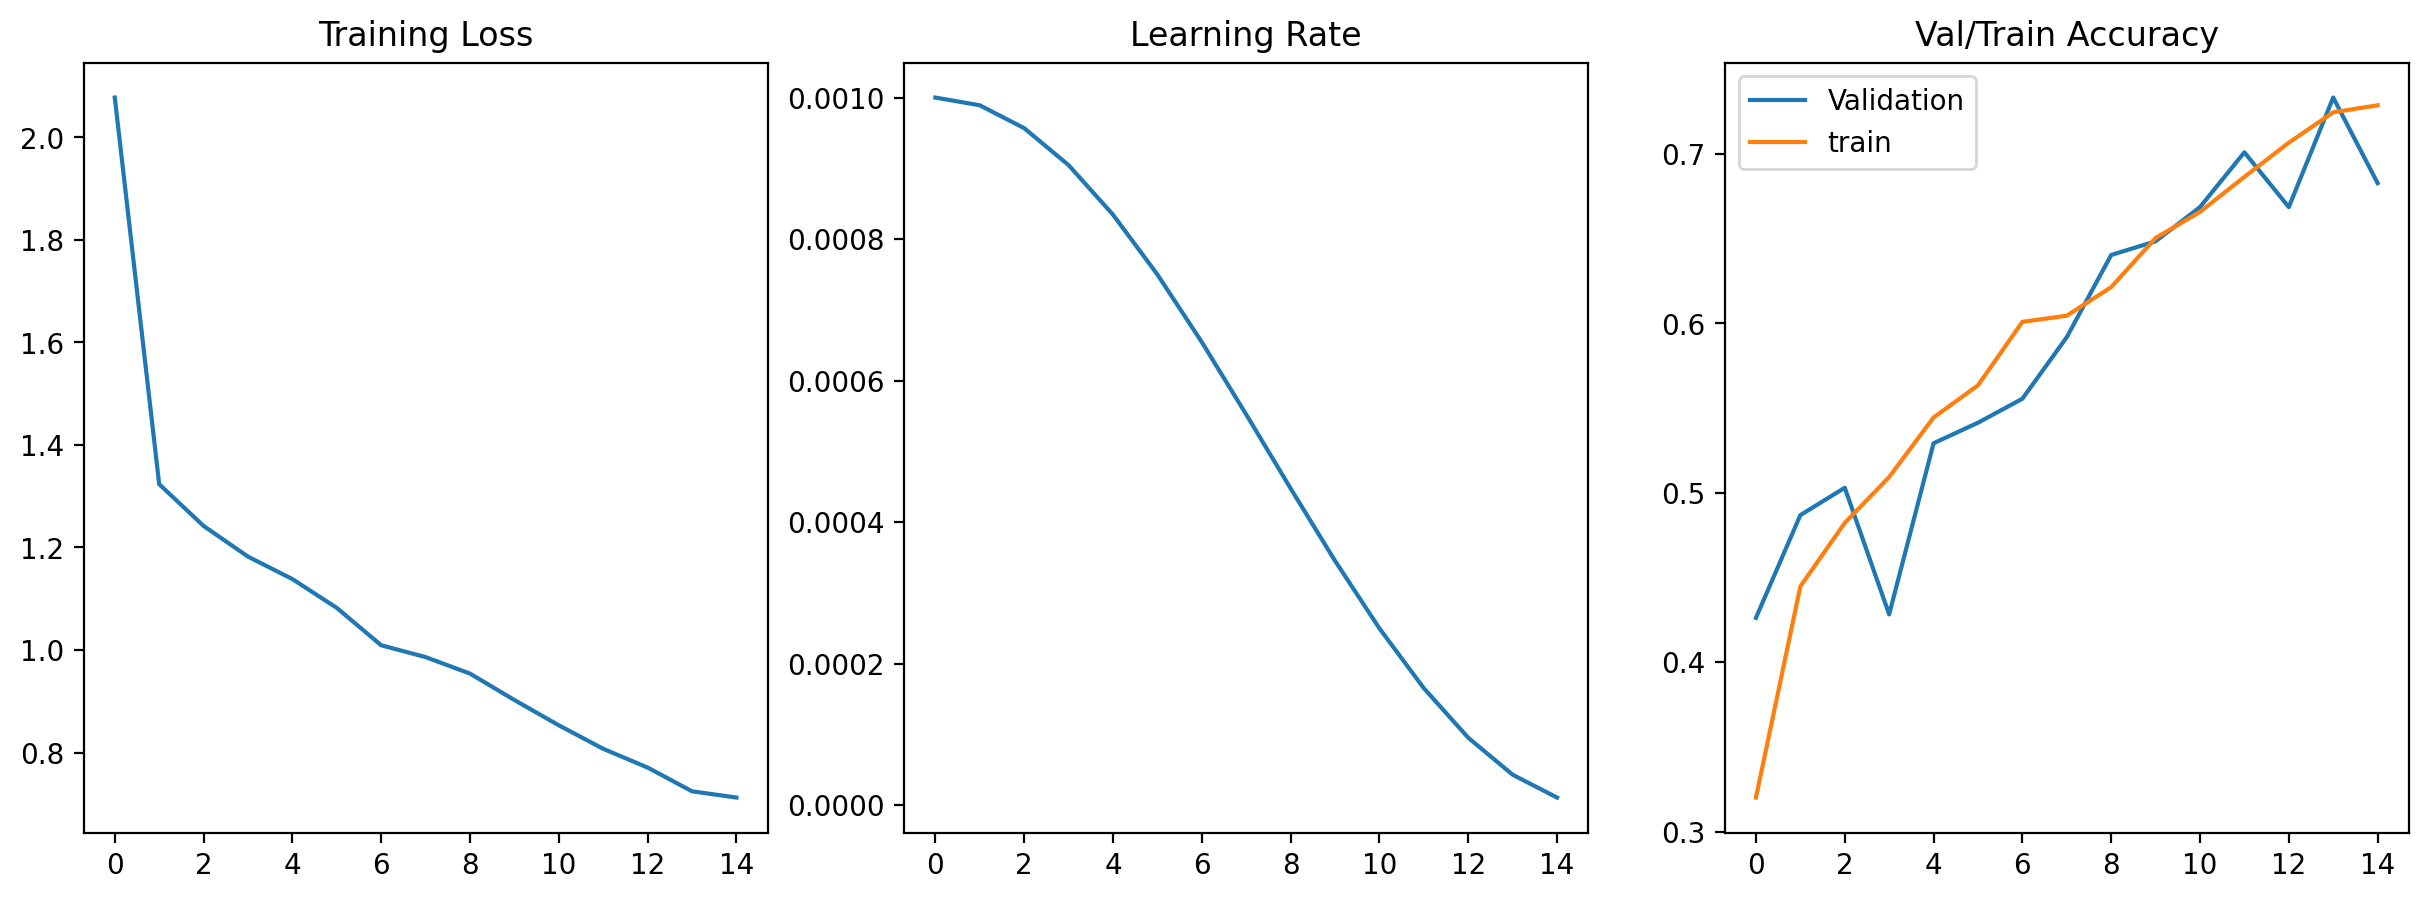

Patience REM :  1


In [164]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

## the following lists will be used to plot the loss and accuracy curves by keeping track of the values over epochs
train_losses = []
cross_accs = []
train_accs = []
lr = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, device, ldl, ldl*batch_size)
    CurrentScore = compute_accuracy(val_loader, model)

    lr.append(optimizer.param_groups[0]['lr'])
    train_losses.append(train_loss)
    cross_accs.append(CurrentScore)
    train_accs.append(train_acc)
    clear_output(wait=True) # wait for all plots to be shown, then erase them and display the updated ones

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, lr: {lr[-1]:.7f}')
    print(f'Validation Acc: {CurrentScore:.4f}, Train Acc: {train_acc:.4f}')
    scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(train_losses)
    axs[0].set_title('Training Loss')
    axs[1].plot(lr)
    axs[1].set_title('Learning Rate')
    axs[2].plot(cross_accs, label="Validation")
    axs[2].plot(train_accs, label = "train")
    axs[2].set_title('Val/Train Accuracy')
    axs[2].legend()
    plt.show(block=False)
    print("Patience REM : ", epoch - best_epoch)
    if CurrentScore > bestScore:
        bestScore = CurrentScore
        best_epoch = epoch
        torch.save(model.state_dict(), 'sad_model.pt')
    elif epoch - best_epoch >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Training stopped.')
        torch.save(combined_model.state_dict(), f'model_epoch_{epoch}.pt')
        break

In [165]:
torch.save(model, "/kaggle/working/GoogleNetrewan.pth")

In [166]:
submn = pd.DataFrame({'epoch' : np.arange(len(train_losses)),'train loss': train_losses,'cross accuracy':cross_accs, 'train accuracy':train_accs})
submn.to_csv('GoogleNetrewan.csv', index=False)

In [167]:
import time
model.eval() 
infloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False) ## create a dummy datalaoder with batchsize = 1
img= next(iter(infloader))[0] ## takes next batch from this dataloader which is just 1 sample
img = img.to(device)
start = time.time() ## record start time
_= model(img)
end = time.time() ## records end time
print(end - start)

0.08885455131530762


In [168]:
# import pandas as pd
# import matplotlib.pyplot as plt
# ResNet = pd.read_csv('/kaggle/input/denseandreswithout/ResNeXtO.csv')
# ResNet_Train = ResNet['train accuracy']
# plt.plot(x, ResNet_Train, label='ResNet')

# plt.xlabel('Epochs')
# plt.ylabel('Train Accuracy')
# plt.legend()
# plt.show()

In [169]:
# import pandas as pd
# import matplotlib.pyplot as plt
# AlexNet2 = pd.read_csv('/kaggle/working/AlexNet2.csv')
# AlexNet2_Train = AlexNet2['train accuracy']
# plt.plot(x, AlexNet2_Train, label='AlexNet2')

# plt.xlabel('Epochs')
# plt.ylabel('Train Accuracy')
# plt.legend()
# plt.show()

In [170]:
# import pandas as pd
# import matplotlib.pyplot as plt
# MobileNet2 = pd.read_csv('/kaggle/working/MobileNet2.csv')
# MobileNet2_Train = MobileNet2['train accuracy']
# plt.plot(x, MobileNet2_Train, label='MobileNet2')

# plt.xlabel('Epochs')
# plt.ylabel('Train Accuracy')
# plt.legend()
# plt.show()

In [171]:
# import pandas as pd
# import matplotlib.pyplot as plt
# DenseNet = pd.read_csv('/kaggle/input/denseandreswithout/DenseNet O.csv')
# DenseNet_Train = DenseNet['train accuracy']
# plt.plot(x, DenseNet_Train, label='DenseNet')

# plt.xlabel('Epochs')
# plt.ylabel('Train Accuracy')
# plt.legend()
# plt.show()

In [172]:
# import pandas as pd
# import matplotlib.pyplot as plt
# DenseNet = pd.read_csv('/kaggle/input/denseandreswithout/DenseNet O.csv')
# DenseNet_Val = DenseNet['cross accuracy']
# plt.plot(x, DenseNet_Val, label='DenseNet')

# plt.xlabel('Epochs')
# plt.ylabel('Validation Accuracy')
# plt.legend()
# plt.show()

In [173]:
# import pandas as pd
# import matplotlib.pyplot as plt
# ResNet = pd.read_csv('/kaggle/input/denseandreswithout/ResNeXtO.csv')
# ResNet_Val = ResNet['cross accuracy']
# plt.plot(x, ResNet_Val, label='ResNet')

# plt.xlabel('Epochs')
# plt.ylabel('Validation Accuracy')
# plt.legend()
# plt.show()

In [174]:
# import pandas as pd
# import matplotlib.pyplot as plt
# MobileNet2 = pd.read_csv('/kaggle/working/MobileNet2.csv')
# MobileNet2_Val = ResNet['cross accuracy']
# plt.plot(x, MobileNet2_Val, label='MobileNet2')

# plt.xlabel('Epochs')
# plt.ylabel('Validation Accuracy')
# plt.legend()
# plt.show()

In [175]:
# import pandas as pd
# import matplotlib.pyplot as plt
# AlexNet2 = pd.read_csv('/kaggle/working/AlexNet2.csv')
# AlexNet2_Val = ResNet['cross accuracy']
# plt.plot(x, AlexNet2_Val, label='AlexNet2')

# plt.xlabel('Epochs')
# plt.ylabel('Validation Accuracy')
# plt.legend()
# plt.show()

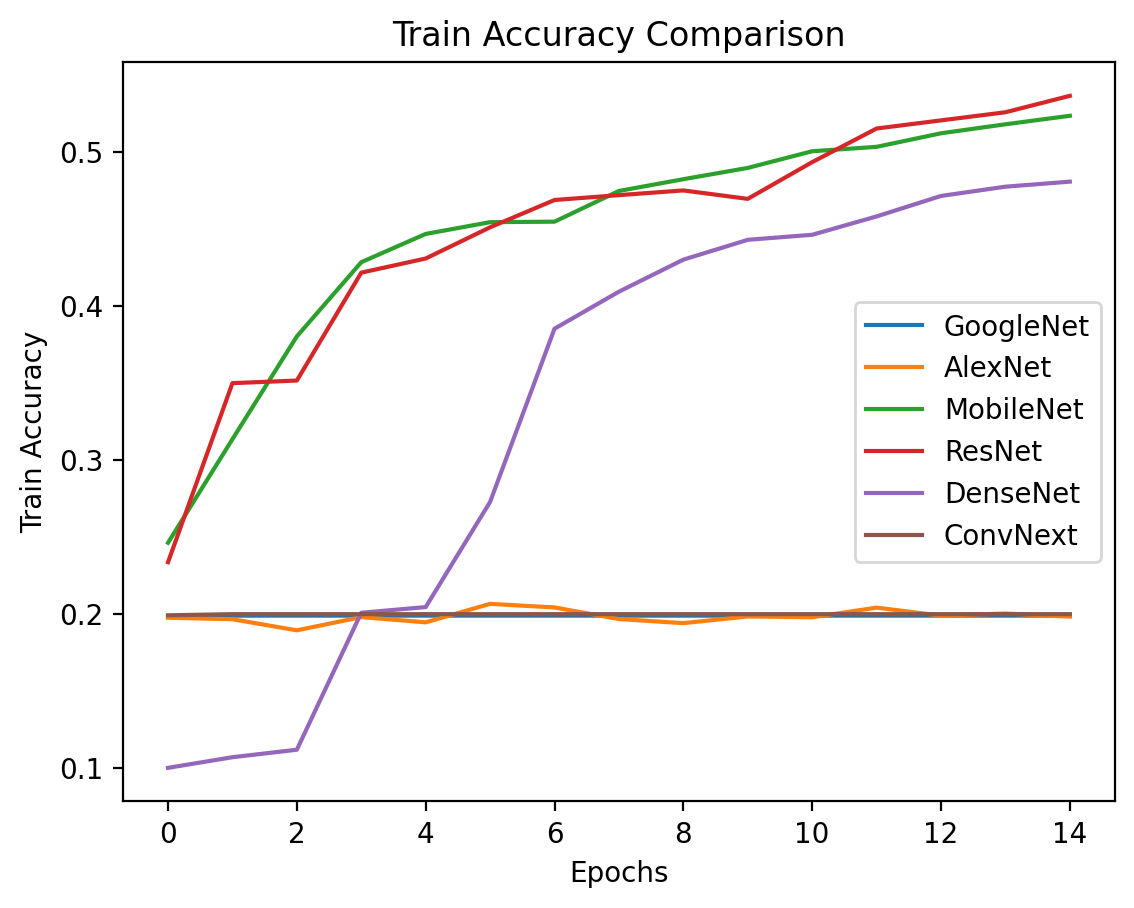

In [177]:
# import pandas as pd
# import matplotlib.pyplot as plt

# GoogleNet = pd.read_csv('/kaggle/input/tryyyy/Google2.csv')
# AlexNet = pd.read_csv('/kaggle/input/tryyyy/AlexNet2.csv')
# MobileNet = pd.read_csv('/kaggle/input/tryyyy/MobileNet2.csv')
# ResNet = pd.read_csv('/kaggle/input/tryyyy/ResNeXtO.csv')
# DenseNet = pd.read_csv('/kaggle/input/tryyyy/DenseNet O.csv')
# ConvNext = pd.read_csv('/kaggle/input/convvv/ConvNext2.csv')

# GoogleNet_Train = GoogleNet['train accuracy']
# AlexNet_Train = AlexNet['train accuracy']
# MobileNet_Train = MobileNet['train accuracy']
# ResNet_Train = ResNet['train accuracy']
# DenseNet_Train = DenseNet['train accuracy']
# ConvNext_Train = ConvNext['train accuracy']
# x = GoogleNet['epoch']

# plt.plot(x, GoogleNet_Train, label='GoogleNet')
# plt.plot(x, AlexNet_Train, label='AlexNet')
# plt.plot(x, MobileNet_Train, label='MobileNet')
# plt.plot(x, ResNet_Train, label='ResNet')
# plt.plot(x, DenseNet_Train, label='DenseNet')
# plt.plot(x, ConvNext_Train, label='ConvNext')

# plt.xlabel('Epochs')
# plt.ylabel('Train Accuracy')
# plt.title('Train Accuracy Comparison')
# plt.legend()
# plt.show()

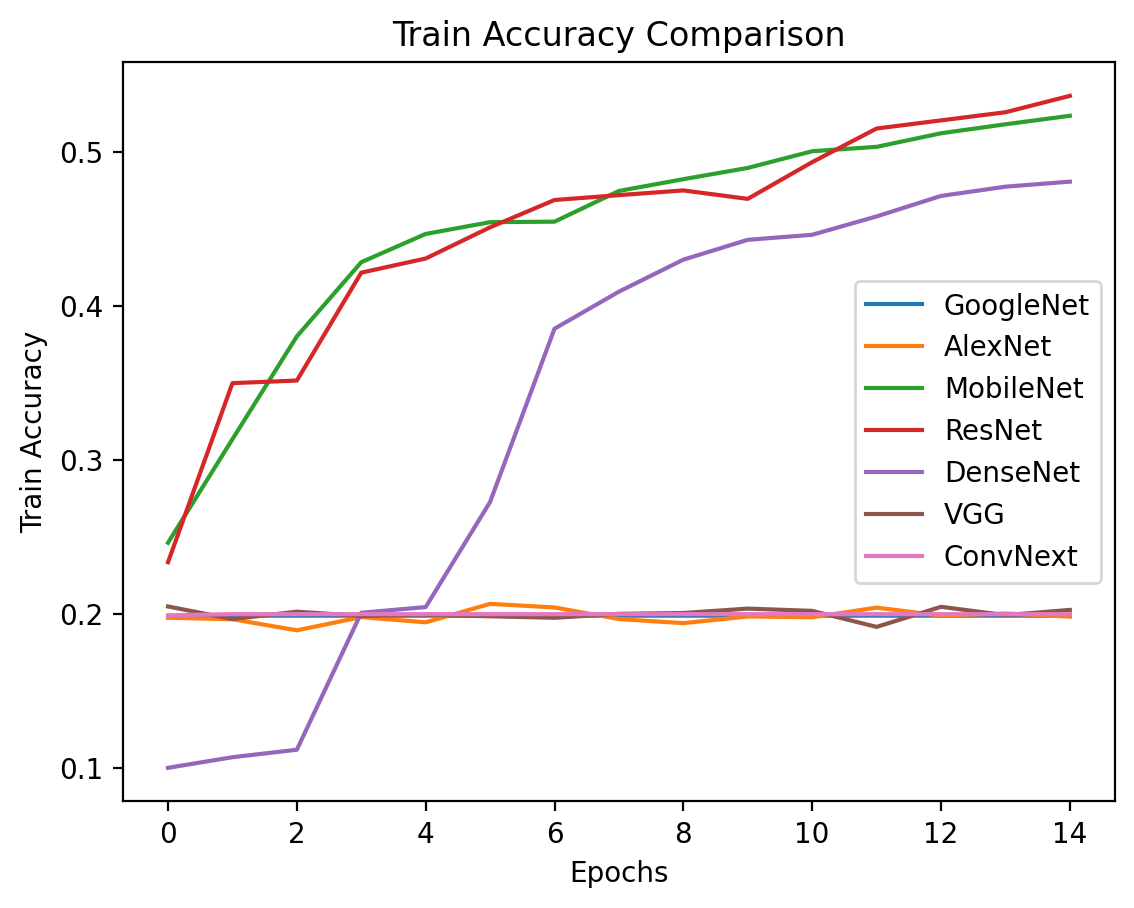

In [184]:
import pandas as pd
import matplotlib.pyplot as plt


VGG = pd.read_csv('/kaggle/working/VGG2.csv')
GoogleNet = pd.read_csv('/kaggle/input/tryyyy/Google2.csv')
AlexNet = pd.read_csv('/kaggle/input/tryyyy/AlexNet2.csv')
MobileNet = pd.read_csv('/kaggle/input/tryyyy/MobileNet2.csv')
ResNet = pd.read_csv('/kaggle/input/tryyyy/ResNeXtO.csv')
DenseNet = pd.read_csv('/kaggle/input/tryyyy/DenseNet O.csv')
ConvNext = pd.read_csv('/kaggle/input/convvv/ConvNext2.csv')

GoogleNet_Train = GoogleNet['train accuracy']
AlexNet_Train = AlexNet['train accuracy']
MobileNet_Train = MobileNet['train accuracy']
ResNet_Train = ResNet['train accuracy']
DenseNet_Train = DenseNet['train accuracy']
VGG_Train = VGG['train accuracy']
ConvNext_Train = ConvNext['train accuracy']
x = GoogleNet['epoch']

plt.plot(x, GoogleNet_Train, label='GoogleNet')
plt.plot(x, AlexNet_Train, label='AlexNet')
plt.plot(x, MobileNet_Train, label='MobileNet')
plt.plot(x, ResNet_Train, label='ResNet')
plt.plot(x, DenseNet_Train, label='DenseNet')
plt.plot(x, VGG_Train, label='VGG')
plt.plot(x, ConvNext_Train, label='ConvNext')

plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy Comparison')
plt.legend()
plt.show()

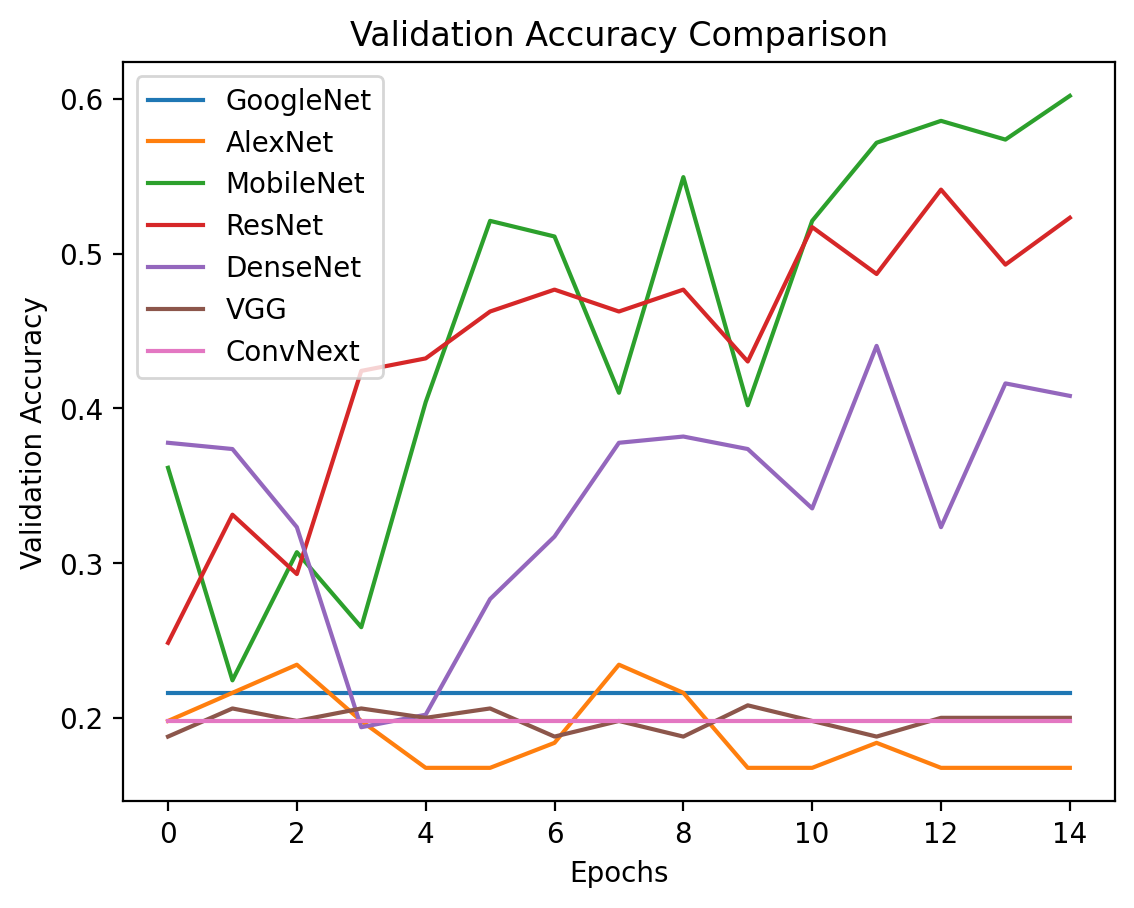

In [185]:
import pandas as pd
import matplotlib.pyplot as plt

VGG = pd.read_csv('/kaggle/working/VGG2.csv')
GoogleNet = pd.read_csv('/kaggle/input/tryyyy/Google2.csv')
AlexNet = pd.read_csv('/kaggle/input/tryyyy/AlexNet2.csv')
MobileNet = pd.read_csv('/kaggle/input/tryyyy/MobileNet2.csv')
ResNet = pd.read_csv('/kaggle/input/tryyyy/ResNeXtO.csv')
DenseNet = pd.read_csv('/kaggle/input/tryyyy/DenseNet O.csv')
ConvNext = pd.read_csv('/kaggle/input/convvv/ConvNext2.csv')



GoogleNet_val = GoogleNet['cross accuracy']
AlexNet_val = AlexNet['cross accuracy']
MobileNet_val = MobileNet['cross accuracy']
ResNet_val = ResNet['cross accuracy']
DenseNet_val = DenseNet['cross accuracy']
VGG_val = VGG['cross accuracy']
ConvNext_val = ConvNext['cross accuracy']
x = GoogleNet['epoch']

plt.plot(x, GoogleNet_val, label='GoogleNet')
plt.plot(x, AlexNet_val, label='AlexNet')
plt.plot(x, MobileNet_val, label='MobileNet')
plt.plot(x, ResNet_val, label='ResNet')
plt.plot(x, DenseNet_val, label='DenseNet')
plt.plot(x, VGG_val, label='VGG')
plt.plot(x, ConvNext_val, label='ConvNext')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.show()

In [183]:
GoogleNet_val = GoogleNet['cross accuracy'].max()
AlexNet_val = AlexNet['cross accuracy'].max()
MobileNet_val = MobileNet['cross accuracy'].max()
ResNet_val = ResNet['cross accuracy'].max()
DenseNet_val = DenseNet['cross accuracy'].max()
VGG_val = VGG['cross accuracy'].max()
ConvNext_val = ConvNext['cross accuracy'].max()

print(GoogleNet_val, "--",AlexNet_val, "--", MobileNet_val, "--", ResNet_val, "--", DenseNet_val, "--",VGG_val, "--", ConvNext_val )

0.7434343434343434 -- 0.6626262626262627 -- 0.7515151515151515 -- 0.6585858585858586 -- 0.6888888888888889 -- 0.4929292929292929 -- 0.9454545454545454


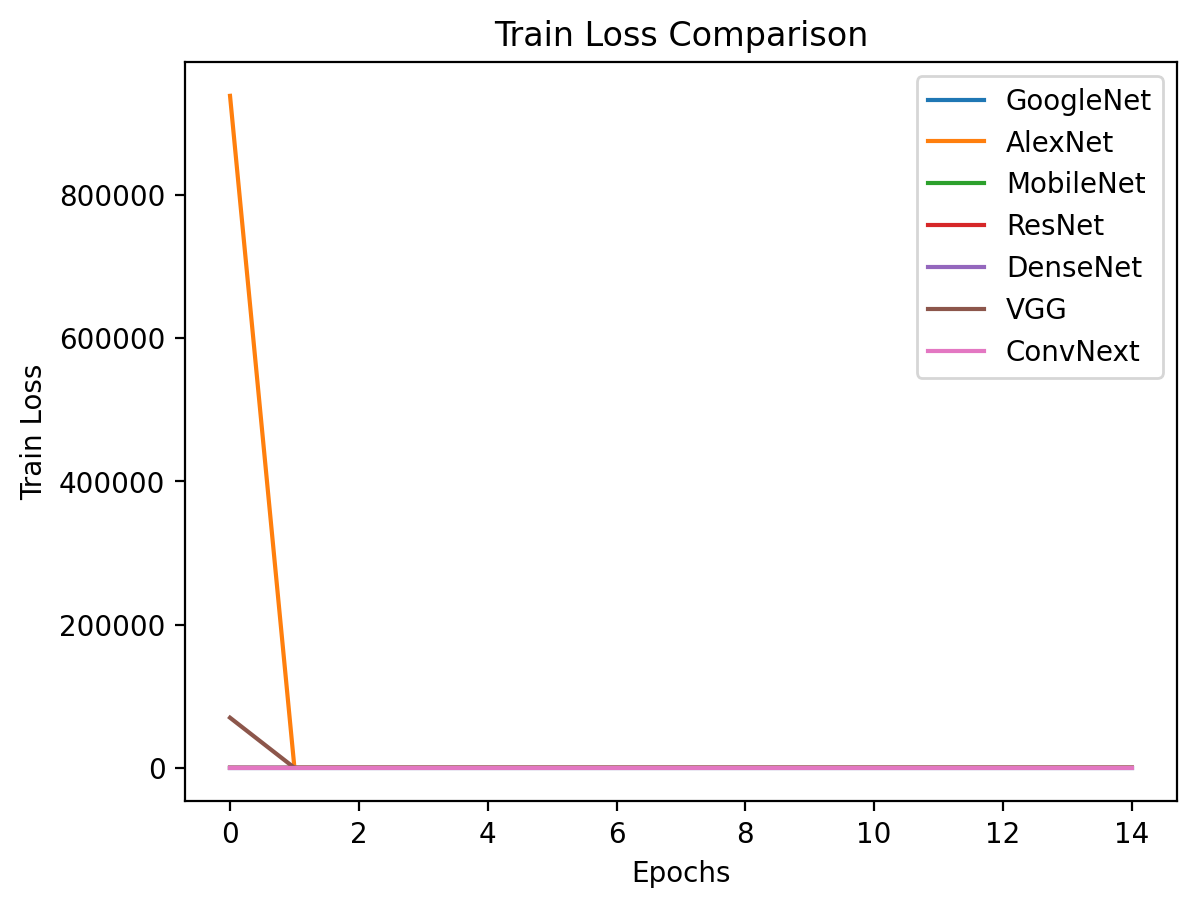

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

VGG = pd.read_csv('/kaggle/working/VGG2.csv')
GoogleNet = pd.read_csv('/kaggle/input/tryyyy/Google2.csv')
AlexNet = pd.read_csv('/kaggle/input/tryyyy/AlexNet2.csv')
MobileNet = pd.read_csv('/kaggle/input/tryyyy/MobileNet2.csv')
ResNet = pd.read_csv('/kaggle/input/tryyyy/ResNeXtO.csv')
DenseNet = pd.read_csv('/kaggle/input/tryyyy/DenseNet O.csv')
ConvNext = pd.read_csv('/kaggle/input/convvv/ConvNext2.csv')

GoogleNet_loss = GoogleNet['train loss']
AlexNet_loss = AlexNet['train loss']
MobileNet_loss = MobileNet['train loss']
ResNet_loss = ResNet['train loss']
DenseNet_loss = DenseNet['train loss']
VGG_loss = VGG['train loss']
ConvNext_loss = ConvNext['train loss']
x = GoogleNet['epoch']

plt.plot(x, GoogleNet_loss, label='GoogleNet')
plt.plot(x, AlexNet_loss, label='AlexNet')
plt.plot(x, MobileNet_loss, label='MobileNet')
plt.plot(x, ResNet_loss, label='ResNet')
plt.plot(x, DenseNet_loss, label='DenseNet')
plt.plot(x, VGG_loss, label='VGG')
plt.plot(x, ConvNext_loss, label='ConvNext')

plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss Comparison')
plt.legend()
plt.show()

In [ ]:
# loaded_model = torch.load("/kaggle/working/VGG.pth")

In [ ]:
# torch.backends.cudnn.benchmark = True  # May improve performance but use with caution

In [ ]:
def getPreds(dataloader, models):
    preds = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)
            preds.extend(predictions.cpu().numpy()+1)
            labels.append(batch[2])
    return preds, labels

In [ ]:
preds,names = getPreds(test_loader, model)
names = names[0]
names = [x.split("/")[-1].split(".")[0] for x in names]
print(preds)
preds = [p+1 for p in preds]